In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Lol Frames"

base_dir = "/content/drive/MyDrive/Lol Frames"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Lol Frames


In [2]:
!pip install split-folders

In [2]:
# Import libraries
import os
import cv2
import numpy as np

# Visualize images
import matplotlib.pyplot as plt

# Separate folders into train, test and valid
import splitfolders

# Everything related to the model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
folder = base_dir
count = 0

# Rename the dataset images
for fol in os.listdir(folder):
    for f in os.listdir(folder+"/"+fol):
        old_name = f"{folder}/{fol}/{f}"
        new_name = f"{folder}/{fol}/{fol}{count}.jpg"
        os.rename(old_name, new_name)
        count += 1
    count = 0

# Split into train and test
splitfolders.ratio(folder,                # The location of dataset
                   output="lol_data", # The output location
                   seed=42,               # The number of seed
                   ratio=(.7, .2, .1),    # The ratio of splited dataset
                   group_prefix=None,     # Dataset contains more than one kind of file like ".jpg", ".pdf", etc.
                )

Copying files: 1260 files [00:17, 72.77 files/s]


In [4]:
# Create directorio for train, test and valid
base_dir = 'lol_data'

test_dir = base_dir + '/' + 'test'
train_dir = base_dir + '/' + 'train'
validation_dir = base_dir + '/' + 'val'

In [5]:
# Normalize images and add augmentation
train_data = ImageDataGenerator(rescale=1./255,

								rotation_range=40,
								width_shift_range=0.3,
								height_shift_range=0.2,
								shear_range=0.2,
								zoom_range=0.25,
								horizontal_flip=True)

val_data = ImageDataGenerator(rescale=1./255)

# Get out train and valid ready to make our model
train_generator = train_data.flow_from_directory(
							train_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

val_generator = val_data.flow_from_directory(
							validation_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

Found 880 images belonging to 4 classes.
Found 250 images belonging to 4 classes.


### __First Model__

In [ ]:
# Use transfer learning with vgg16
vgg_model = VGG16(weights='imagenet',
                include_top = False,
                input_shape=(220, 220, 3))

# Get every but the last layer from vgg16
model = models.Sequential()
model.add(vgg_model)
# Add new layers to train our dataset
model.add(layers.Flatten())
model.add(layers.Dense(255, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

vgg_model.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 255)               4700415   
                                                                 
 dense_5 (Dense)             (None, 512)               131072    
                                                                 
 dense_6 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 19548227 (74.57 MB)
Trainable params: 4833539 (18.44 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.categorical_crossentropy,metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=10, steps_per_epoch = 32,validation_data=val_generator, validation_steps = 25)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.5914 - accuracy: 0.4004

32/32 [==============================] - 433s 14s/step - loss: 1.5914 - accuracy: 0.4004 - val_loss: 0.9162 - val_accuracy: 0.6560
Epoch 2/10
32/32 [==============================] - 293s 9s/step - loss: 0.6692 - accuracy: 0.7461
Epoch 3/10
32/32 [==============================] - 290s 9s/step - loss: 0.3195 - accuracy: 0.8906
Epoch 4/10
32/32 [==============================] - 288s 9s/step - loss: 0.2594 - accuracy: 0.9180
Epoch 5/10
32/32 [==============================] - 285s 9s/step - loss: 0.3412 - accuracy: 0.8574
Epoch 6/10
32/32 [==============================] - 288s 9s/step - loss: 0.2780 - accuracy: 0.8945
Epoch 7/10
32/32 [==============================] - 285s 9s/step - loss: 0.1294 - accuracy: 0.9512
Epoch 8/10
32/32 [==============================] - 288s 9s/step - loss: 0.0798 - accuracy: 0.9688
Epoch 9/10
32/32 [==============================] - 284s 9s/step - loss: 0.2495 - accuracy: 0.9160
Epoch 10/10
 6/32 [====>.........................] - ETA: 3:49 - loss: 0.0917

In [ ]:
model.save('Lol_vgg1.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


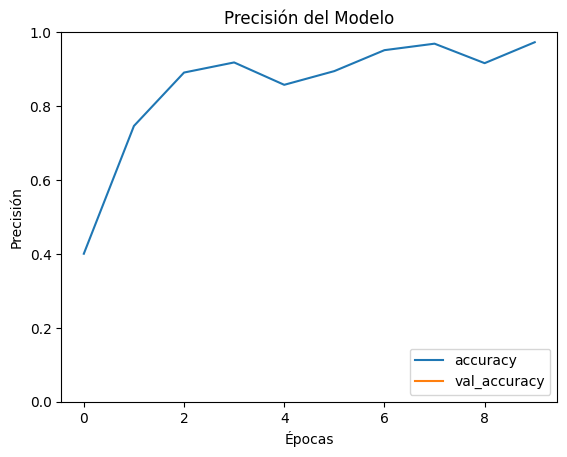

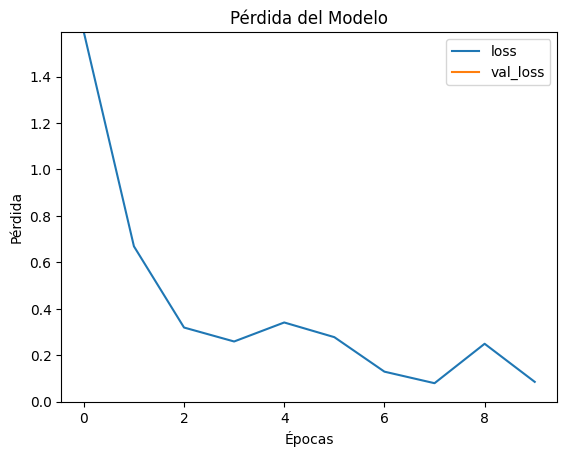

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Precisión del Modelo')
plt.show()

# Graficar la pérdida
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.legend(loc='upper right')
plt.title('Pérdida del Modelo')
plt.show()

Precisión para la clase 'anivia': 19.30%
Precisión para la clase 'aurelionsol': 35.44%
Precisión para la clase 'drmundo': 28.81%
Precisión para la clase 'garen': 23.64%


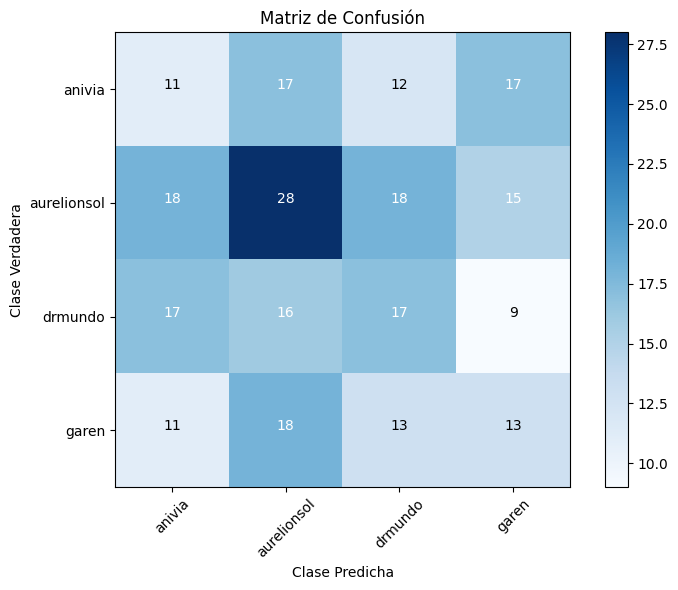

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# Obteniendo los nombres de las clases
train_dir = '/content/drive/MyDrive/Lol Frames/lol_data/train'  # Reemplaza con la ruta correcta
class_names = os.listdir(train_dir)



# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Crear figura y ejes para la visualización
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

# Establecer los nombres de las clases como etiquetas
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Etiquetas de ejes
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

# Anotar valores en la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i][j]),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i][j] > conf_matrix.max() / 2 else "black")

# Calcular y mostrar precisión por clase
accuracy_per_class = {}
for i in range(len(class_names)):
    total = sum(conf_matrix[i])
    accuracy = conf_matrix[i][i] / total if total > 0 else 0
    accuracy_per_class[class_names[i]] = accuracy * 100
    print(f"Precisión para la clase '{class_names[i]}': {accuracy * 100:.2f}%")

plt.tight_layout()
plt.show()


### __Second Model__

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

# Use transfer learning with ResNet50
resnet_model = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=(220, 220, 3))

# Get every but the last layer from ResNet50
model_resnet = models.Sequential()
model_resnet.add(resnet_model)
# Add new layers to train our dataset
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dense(4, activation='softmax'))

# Freeze ResNet50 layers to not retrain
resnet_model.trainable = False

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [7]:
# Compile the model with our configurations
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=losses.categorical_crossentropy, metrics=['acc'])

In [8]:
history2 = model_resnet.fit(train_generator, epochs=20, steps_per_epoch = 50,
				validation_data=val_generator, validation_steps = 35)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 1.4752 - acc: 0.2675

50/50 [==============================] - 200s 4s/step - loss: 1.4752 - acc: 0.2675 - val_loss: 1.4530 - val_acc: 0.3160
Epoch 2/20
50/50 [==============================] - 162s 3s/step - loss: 1.4422 - acc: 0.2850
Epoch 3/20
50/50 [==============================] - 146s 3s/step - loss: 1.5169 - acc: 0.2912
Epoch 4/20
50/50 [==============================] - 151s 3s/step - loss: 1.4187 - acc: 0.2988
Epoch 5/20
50/50 [==============================] - 151s 3s/step - loss: 1.4072 - acc: 0.3338
Epoch 6/20
50/50 [==============================] - 147s 3s/step - loss: 1.3675 - acc: 0.3587
Epoch 7/20
50/50 [==============================] - 153s 3s/step - loss: 1.3834 - acc: 0.3250
Epoch 8/20
50/50 [==============================] - 146s 3s/step - loss: 1.3890 - acc: 0.3537
Epoch 9/20
50/50 [==============================] - 160s 3s/step - loss: 1.3605 - acc: 0.3625
Epoch 10/20
50/50 [==============================] - 145s 3s/step - loss: 1.3201 - acc: 0.3600
Epoch 11/20
50/50 [==============

In [9]:
model_resnet.save('Lol_ResNet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


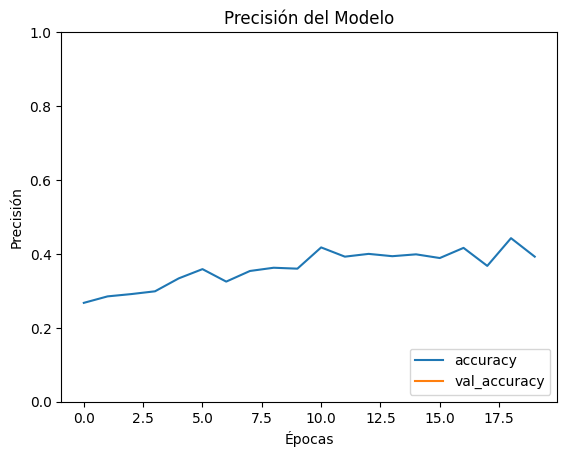

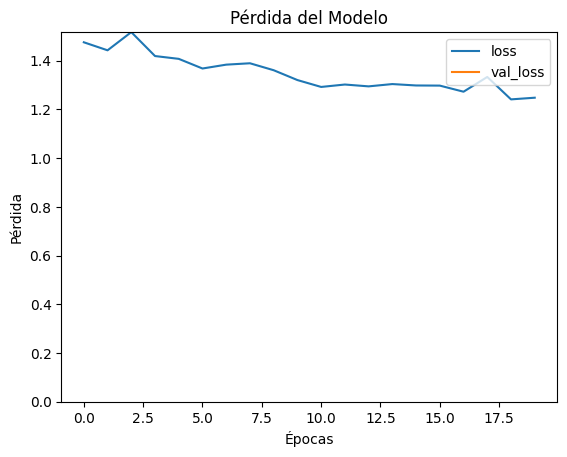

In [16]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.plot(history2.history['acc'], label='accuracy')
plt.plot(history2.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Precisión del Modelo')
plt.show()

# Graficar la pérdida
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim([0, max(max(history2.history['loss']), max(history2.history['val_loss']))])
plt.legend(loc='upper right')
plt.title('Pérdida del Modelo')
plt.show()

### __Test de nuestro mejor modelo__

In [27]:
# Modelo entrenado con todo nuestro dataset
best_model = models.load_model("Lol_vgg1.h5")

# Getting the class names
base_dir = 'lol_data'
train_dir = base_dir + '/' + 'train'

class_names = os.listdir(train_dir)
labels = {}
for i in range(len(class_names)):
    labels[i] = class_names[i]
print(labels)

{0: 'anivia', 1: 'aurelionsol', 2: 'drmundo', 3: 'garen'}


1/1 [==============================] - 1s 833ms/step


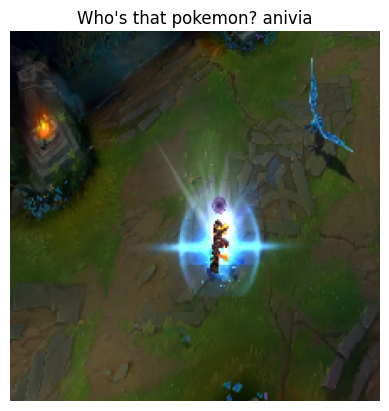

In [35]:
image = load_img('/content/ability_0034_E1.jpg', target_size=(220, 220))

img = np.array(image)
img = img / 255.0
img = img.reshape(1,220,220,3)

label = best_model.predict(img)

index = np.argmax(label)
plt.imshow(image)
plt.axis("off")

plt.title("El campeon detectado es: %s" %(labels[index]));